In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [4]:
mix = QuantumCircuit(1)
mix.rx(np.pi, 0)

ix = QuantumCircuit(1)
ix.rx(3*np.pi, 0)
mix.draw()

┌───────┐
q_0: ┤ Rx(π) ├
     └───────┘

In [5]:
miy = QuantumCircuit(1)
miy.ry(np.pi, 0)
miy.draw()

┌───────┐
q_0: ┤ Ry(π) ├
     └───────┘

In [6]:
miz = QuantumCircuit(1)
miz.rz(np.pi, 0)

iz = QuantumCircuit(1)
iz.rz(3*np.pi, 0)
miz.draw()

┌───────┐
q_0: ┤ Rz(π) ├
     └───────┘

In [7]:
mi = QuantumCircuit(1)
mi.rz(2*np.pi, 0)
mi.draw()

┌────────┐
q_0: ┤ Rz(2π) ├
     └────────┘

In [52]:
numLayer = 3
numQubit = 3
global iterations
global noisy

In [53]:
#Create unitaries here
unitary_param_1 = np.array([])
for i in range(0, 8):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

unitary_param_1 = [3.24383098, 3.50187279, 1.26248366, 1.99354817, 4.28031102, 5.99851666, 3.03466457, 4.21065453]

In [54]:
print(unitary_param_1)

[3.24383098, 3.50187279, 1.26248366, 1.99354817, 4.28031102, 5.99851666, 3.03466457, 4.21065453]


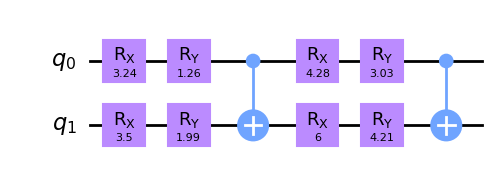

In [55]:
# First unitary
size = 2
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [56]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [57]:
def createEqSuperposQuaternionSE():
    temp = QuantumCircuit(3)
    temp.h(0)
    temp.h(1)
    temp.h(2)
    return temp

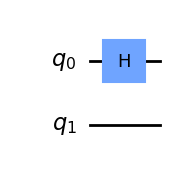

In [74]:
qcTest = QuantumCircuit(2)
qcTest.h(0)
qcTest.draw('mpl')

In [75]:
def createQuantumCircuit(state, numQubit, numLayer):
    circ = QuantumCircuit(7)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperposQuaternionSE()
    circ.append(superPosCircuit, [0, 1, 2])

    circ.append(state, [3, 4])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [4, 5, 6])
    
    custom = miz.to_gate().control(2)
    circ.append(custom, [0, 3, 4])
    custom = iz.to_gate().control(2)
    circ.append(custom, [0, 5, 6])
    
    custom = miy.to_gate().control(2)
    circ.append(custom, [1, 3, 4])
    circ.append(custom, [1, 5, 6])

    custom = mix.to_gate().control(2)
    circ.append(custom, [2, 3, 4])
    custom = ix.to_gate().control(2)
    circ.append(custom, [2, 5, 6])

    circ.x(0)
    custom = mi.to_gate().control(3)
    circ.append(custom, [0, 2, 3, 4])
    circ.append(custom, [0, 2, 5, 6])
    circ.x(0)
    
    circ.append(superPosCircuit.inverse(), [0, 1, 2])
    
    return circ

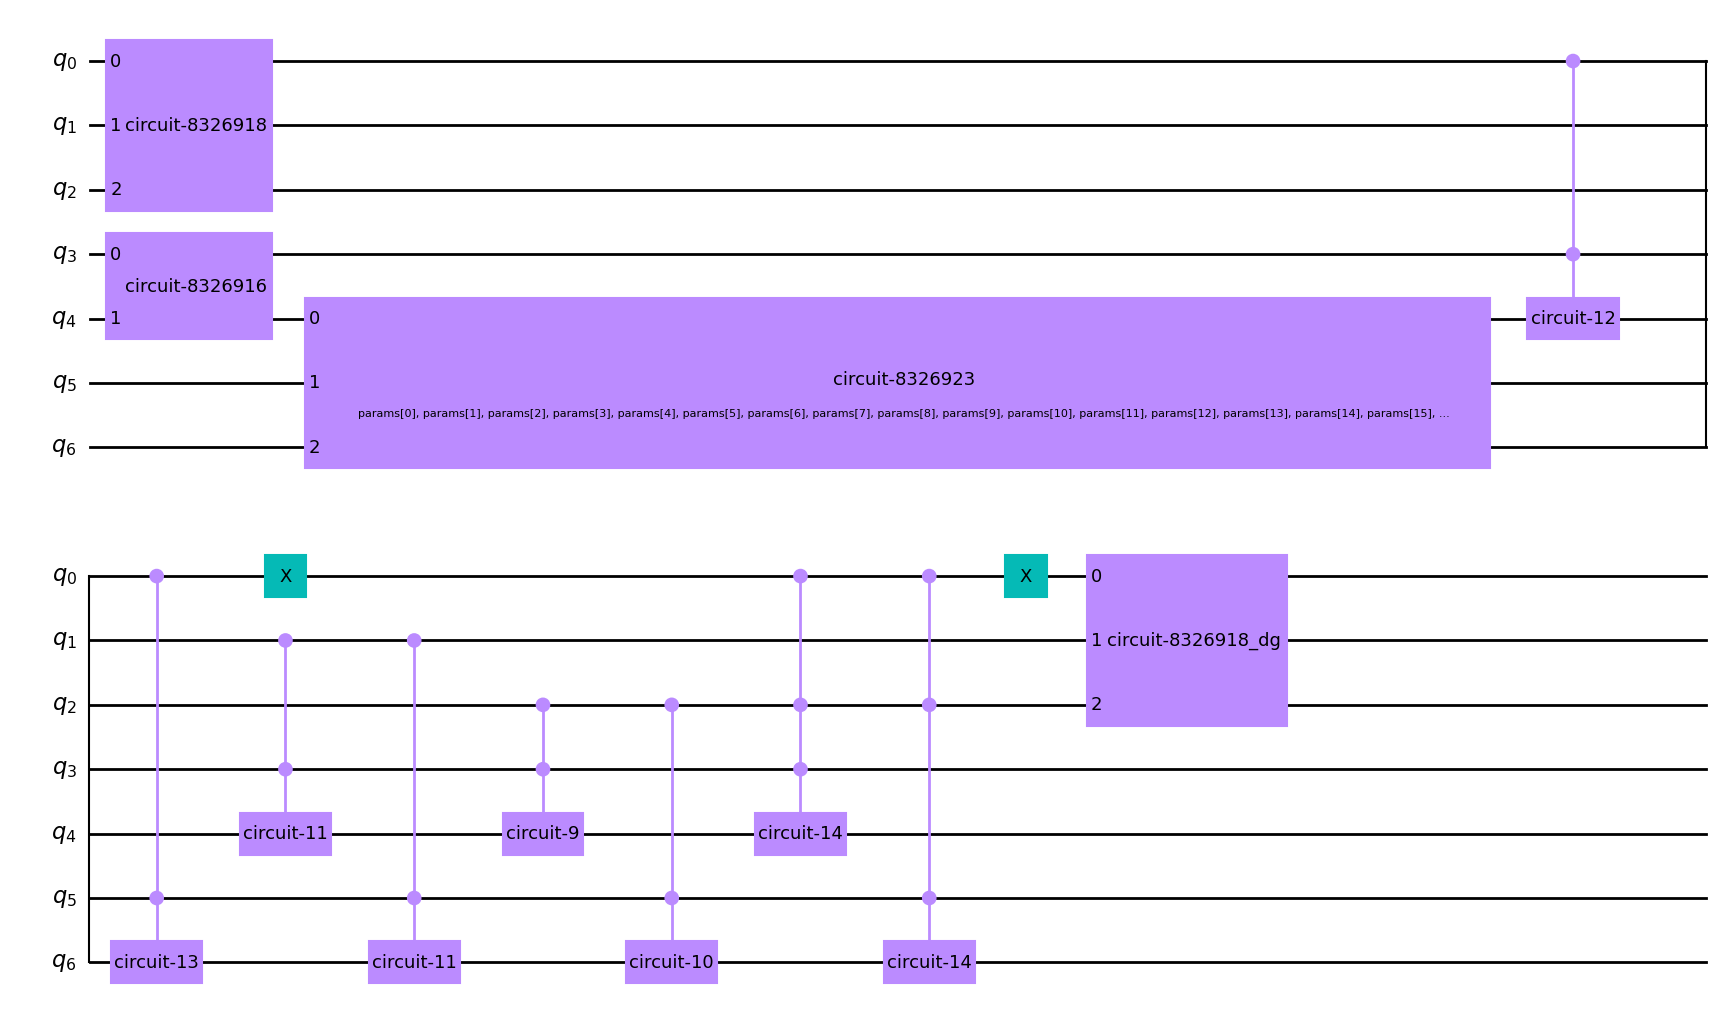

In [76]:
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [77]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [78]:
#Use if noisy
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [79]:
#Create Hamiltonian here
hamiltonian = I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [80]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [81]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [82]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15]), ParameterVectorElement(params[16]), ParameterVectorElement(params[17])])


In [83]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [84]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[3.96527549 1.2810046  1.27327102 2.72123741 0.2337085  0.53530433
 6.10799016 5.07635962 0.89558565 4.41698122 3.92710756 5.95927123
 3.95712534 0.25155782 4.55556477 3.25369515 0.381679   5.41287541]
Initial Cost :  0.3939867026546672


In [85]:
true_value = 0.5

In [87]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.3939867026546672
Loss Value :  0.3206163846921405 1.0%
Loss Value :  0.3204857431879437 2.0%
Loss Value :  0.32084275194287215 3.0%
Loss Value :  0.32084136054890144 4.0%
Loss Value :  0.33430385055958084 5.0%
Loss Value :  0.4308816808418475 6.0%
Loss Value :  0.4307512264673119 7.0%
Loss Value :  0.37017440292975295 8.0%
Loss Value :  0.37401077843024877 9.0%
Loss Value :  0.3740238580659881 10.0%
Loss Value :  0.3982447155719614 11.0%
Loss Value :  0.44498231671642213 12.0%
Loss Value :  0.485959366262754 13.0%
Loss Value :  0.4859548583336819 14.0%
Loss Value :  0.4859314249156643 15.0%
Loss Value :  0.49029014677062493 16.0%
Loss Value :  0.49021749239469287 17.0%
Loss Value :  0.4902999833314423 18.0%
Loss Value :  0.4903956984989959 19.0%
Loss Value :  0.49039183274141446 20.0%
Loss Value :  0.491473285551042 21.0%
Loss Value :  0.4919132140440308 22.0%
Loss Value :  0.491845679563284 23.0%
Loss Value :  0.4926784711248831 24.0%
Loss Value :  0.4942480501934617

In [88]:
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.2551250951477954
Loss Value :  0.2590862744717391 1.0%
Loss Value :  0.2588222353446963 2.0%
Loss Value :  0.2588730375625269 3.0%
Loss Value :  0.29304410358938937 4.0%
Loss Value :  0.27150431671265157 5.0%
Loss Value :  0.2946825255503111 6.0%
Loss Value :  0.32035909111323496 7.0%
Loss Value :  0.3082330617465437 8.0%
Loss Value :  0.291350858314262 9.0%
Loss Value :  0.3113909732838532 10.0%
Loss Value :  0.32018184052921544 11.0%
Loss Value :  0.3154427320970308 12.0%
Loss Value :  0.32062554249250513 13.0%
Loss Value :  0.3148827297429241 14.0%
Loss Value :  0.3048634578286246 15.0%
Loss Value :  0.2952421164928567 16.0%
Loss Value :  0.3123973076603362 17.0%
Loss Value :  0.311064317009859 18.0%
Loss Value :  0.31594018031688614 19.0%
Loss Value :  0.32382175543147285 20.0%
Loss Value :  0.3084335462476388 21.0%
Loss Value :  0.3056636898732405 22.0%
Loss Value :  0.3046781541715973 23.0%
Loss Value :  0.30867537153081986 24.0%
Loss Value :  0.3197315607098888

In [89]:
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.4974204488032991


In [90]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.5
Noiseless :  0.4999502888735285
Noisy :  0.29189788473527356
Noise Resilient Value :  0.4974204488032991


In [49]:
def writeToFile():
    file = open("Q8_GSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [50]:
writeToFile()